In [1]:
import numpy as np
import h5py

# with h5py.File('/home/agah/FontCase/fonts.hdf5','r') as hf:
with h5py.File('..\\fonts.hdf5','r') as hf:
    print('List of arrays in this file: \n', hf.keys())
    data = hf.get('fonts')
    print(data)
    print(data.shape)
    imgC = data[43611,2,:,:]
    imgH = data[43611,7,:,:]
    
    smallDataSize = 5000

    As = data[:smallDataSize,0,:,:]
    Bs = data[:smallDataSize,1,:,:]

List of arrays in this file: 
 KeysView(<HDF5 file "fonts.hdf5" (mode r)>)
<HDF5 dataset "fonts": shape (56443, 62, 64, 64), type "|u1">
(56443, 62, 64, 64)


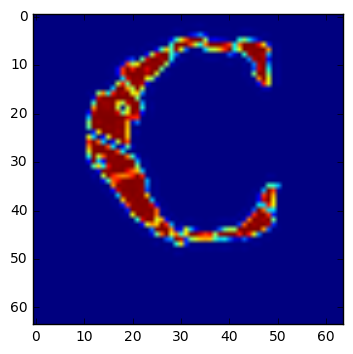

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(imgC)

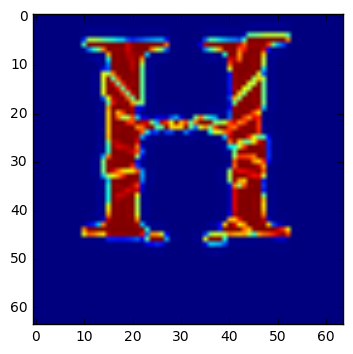

In [3]:
plt.imshow(imgH)

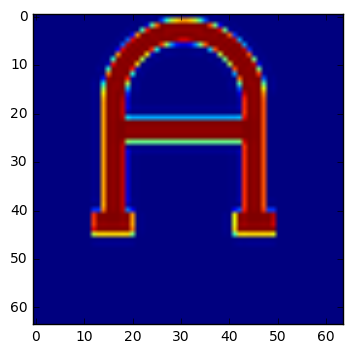

In [4]:
plt.imshow(As[0])

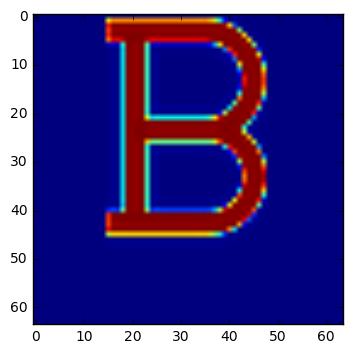

In [5]:
plt.imshow(Bs[0])

In [6]:
print(As.shape)
print(Bs.shape)

(5000, 64, 64)
(5000, 64, 64)


In [7]:
import numpy

def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = numpy.empty(a.shape, dtype=a.dtype)
    shuffled_b = numpy.empty(b.shape, dtype=b.dtype)
    permutation = numpy.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [8]:
As_reshaped = As.reshape((smallDataSize, 64*64))
print(As_reshaped.shape)

Bs_reshaped = Bs.reshape((smallDataSize, 64*64))
print(Bs_reshaped.shape)

As_reshaped, Bs_reshaped = shuffle_in_unison(As_reshaped, Bs_reshaped)


(5000, 4096)
(5000, 4096)


In [9]:
training_size = (int)(smallDataSize * 0.90)
test_size = smallDataSize - training_size

print(training_size)
print(test_size)
print(training_size + test_size == smallDataSize)
As_reshaped_training = As_reshaped[:training_size, :]
Bs_reshaped_training = Bs_reshaped[:training_size, :]

As_reshaped_test = As_reshaped[training_size:, :]
Bs_reshaped_test = Bs_reshaped[training_size:, :]

print(As_reshaped_training.shape)
print(Bs_reshaped_training.shape)
print(As_reshaped_test.shape)
print(Bs_reshaped_test.shape)

4500
500
True
(4500, 4096)
(4500, 4096)
(500, 4096)
(500, 4096)


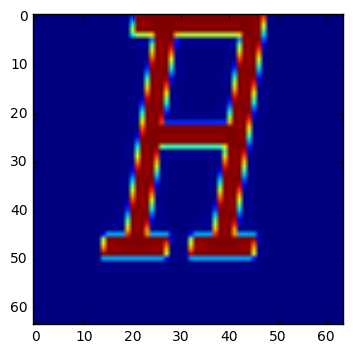

In [10]:
plt.imshow(As_reshaped_training[0,:].reshape((64,64)))

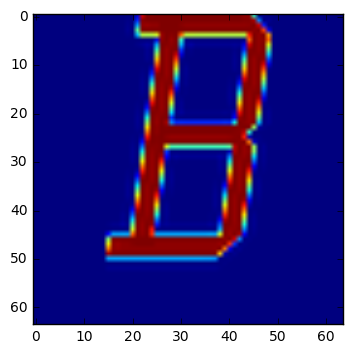

In [11]:
plt.imshow(Bs_reshaped_training[0,:].reshape((64,64)))

In [12]:
print(numpy.unique(As_reshaped_training[0,:]))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  16  17  19  20
  21  22  23  24  26  27  28  29  30  31  36  38  40  41  42  43  44  45
  46  47  48  51  52  53  54  56  57  59  60  62  65  66  69  70  71  72
  73  74  75  77  80  81  83  85  86  90  91  93  96  98 100 103 107 109
 110 111 112 113 116 117 118 119 121 122 123 125 127 130 131 134 135 139
 141 145 146 147 148 149 150 152 153 154 155 156 157 158 159 160 161 166
 167 169 171 172 176 178 180 181 182 184 186 189 190 191 192 193 194 196
 197 199 200 203 205 208 209 210 211 213 214 215 216 217 219 220 221 222
 223 224 225 226 230 233 234 235 236 237 238 239 240 241 242 243 244 245
 246 247 248 249 250 251 252 253 254 255]


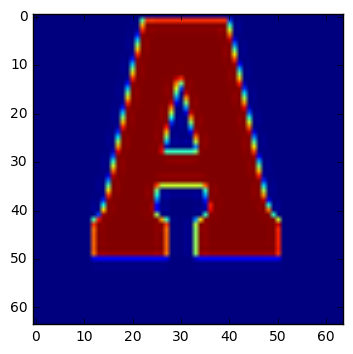

In [13]:
plt.imshow(As_reshaped_test[0,:].reshape((64,64)))

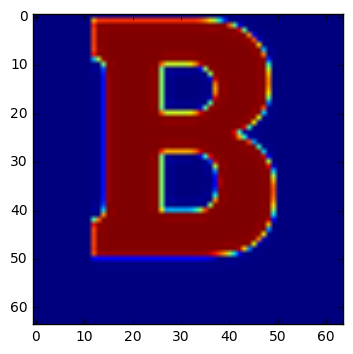

In [14]:
plt.imshow(Bs_reshaped_test[0,:].reshape((64,64)))

In [15]:
from sklearn import svm

import sklearn

class VectorRegression():
    def __init__(self):
        self.clf = svm.SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
                            kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

    def fit(self, X, y):
        n, m = y.shape
        # Fit a separate regressor for each column of y
        self.estimators_ = [sklearn.base.clone(self.clf).fit(X, y[:, i])
                               for i in range(m)]
        return self

    def predict(self, X):
        # Join regressors' predictions
        res = [est.predict(X)[:, np.newaxis] for est in self.estimators_]
        return np.hstack(res)
    
class SingleVectorRegression():
    def __init__(self):
        self.clf = svm.SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
                            kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

    def fit(self, X, y):
        n = y.shape
        # Fit a separate regressor for each column of y
        self.estimator = self.clf.fit(X, y)
        return self

    def predict(self, X):
        # Join regressors' predictions
        res = self.estimator.predict(X)
        return np.hstack(res)
    
class SingleClassifi():
    def __init__(self):
        self.clf = svm.SVD(C=300, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
                            kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

    def fit(self, X, y):
        n = y.shape
        # Fit a separate regressor for each column of y
        self.estimator = self.clf.fit(X, y)
        return self

    def predict(self, X):
        # Join regressors' predictions
        res = self.estimator.predict(X)
        return np.hstack(res)

In [16]:
import pickle

def processBit(bitIndex):

    vr = SingleVectorRegression()
    model = vr.fit(As_reshaped_training, Bs_reshaped_training[:,bitIndex]) 
    
    output = open('data{0}.pkl'.format(bitIndex), 'wb')
    pickle.dump(model, output)
    output.close()
    
    pred = vr.predict(As_reshaped_test)
    predList = [int(v) for v in pred]
    result = (predList == Bs_reshaped_test[:,bitIndex])

    falseList = filter(lambda x:  not x, result)
    trueList = filter(lambda x: x, result)

    falseCount = len(list(falseList))
    correctCount = len(list(trueList))

    assert(falseCount + correctCount == test_size)
    errorRate = falseCount * 1.0 / test_size
    correctRate = correctCount * 1.0 / test_size

    print("Bit {1}, error rate: {0}".format(errorRate * 100.00, bitIndex))
    print("Bit {1}, Correct rate: {0}".format(correctRate * 100.00, bitIndex))


In [17]:
%%time
processBit(0)


Bit 0, error rate: 0.8
Bit 0, Correct rate: 99.2
Wall time: 1min 55s


In [18]:
%%time
processBit(1024)

Bit 1024, error rate: 1.4000000000000001
Bit 1024, Correct rate: 98.6
Wall time: 1min 54s


In [19]:
%%time
processBit(2048)

Bit 2048, error rate: 1.6
Bit 2048, Correct rate: 98.4
Wall time: 1min 54s


In [20]:
%%time
processBit(3000)

Bit 3000, error rate: 4.0
Bit 3000, Correct rate: 96.0
Wall time: 1min 54s


In [21]:
%%time
processBit(4095)

Bit 4095, error rate: 0.4
Bit 4095, Correct rate: 99.6
Wall time: 1min 59s


SVD

In [25]:
import numpy as np
U, s, Vh = np.linalg.svd(As_reshaped_training)


In [27]:
print(U.shape)
print(s.shape)
print(Vh.shape)
print(As_reshaped_training.shape)

(4500, 4500)
(4096,)
(4096, 4096)
(4500, 4096)
